## Gerekli kütüphaneler:
Modelin kurulumu ve eğitim süreci için gerekli tüm paketleri içe aktarılır.

In [ ]:
import sys

sys.path.append("../..")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from utils.cnn.preprocessing import get_data_generators
from utils.utils import plot_training_history

## Konfigürasyonlar:
Model eğitimi için kullanılan temel parametreler tanımlanır. UC Merced dataseti default olarak `.tif` formatlı veriler içerdiği için model eğitilmeden önce `/data/tif2jpg.py` scripti ile tüm veriler `.jpg` formatına dönüştürülür.

In [2]:
data_directory = "../../data/uc_merced"
image_size = (256, 256)
batch_size = 16
epochs = 50
number_of_classes = 21 # uc_merced için 21

## Veriyi yükleme ve ön işleme:
`utils/preprocessing.py` içindeki `get_data_generators` fonksiyonu kullanılarak
eğitim ve doğrulama veri kümeleri hazırlanır.

In [3]:
print("Veri yükleniyor.")
train_gen, val_gen = get_data_generators(data_directory, image_size, batch_size, False)

print("Sınıf indeksleri:", train_gen.class_indices)
print("Eğitim örnekleri:", train_gen.samples)
print("Doğrulama örnekleri:", val_gen.samples)

Veri yükleniyor.
Found 1785 images belonging to 21 classes.
Found 315 images belonging to 21 classes.
Sınıf indeksleri: {'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
Eğitim örnekleri: 1785
Doğrulama örnekleri: 315


## Modelin mimarisi:
Uydu görüntülerini sınıflandırmak üzere tasarlanmış bir Convolutional Neural Network (CNN) modeli oluşturulur.

In [4]:
model = Sequential([
    Conv2D(80, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),

    Conv2D(160, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(160, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(80, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(320, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(number_of_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()

steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

print("Epoch başına adım:", steps_per_epoch)
print("Doğrulama adımları:", validation_steps)

c:\Users\mehmet\Desktop\LandCoverClassifier\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 80)   │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 80)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 160)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 80)     │       115,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     6,553,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,061,157 (26.94 MB)

 Trainable params: 7,061,157 (26.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch başına adım: 111
Doğrulama adımları: 19


## Modelin eğitimi:
Model eğitimi başlatılır ve eğitim süreci boyunca callback mekanizmaları burada kullanılır.

In [5]:
early_stop = EarlyStopping(patience=6, restore_best_weights=True)

print("Model eğitimi başladı.")
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stop]
)

print("Model eğitimi tamamlandı.")

Model eğitimi başladı.


c:\Users\mehmet\Desktop\LandCoverClassifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.0568 - loss: 3.0480 - val_accuracy: 0.0476 - val_loss: 3.0269
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.0487 - loss: 3.0299 - val_accuracy: 0.1016 - val_loss: 2.9492
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.0762 - loss: 2.9845 - val_accuracy: 0.1556 - val_loss: 2.8772
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.1121 - loss: 2.9233 - val_accuracy: 0.2032 - val_loss: 2.7653
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.1777 - loss: 2.7520 - val_accuracy: 0.2381 - val_loss: 2.6032
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.2286 - loss: 2.6444 - val_accuracy: 0.2476 - val_loss: 2.6386
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.2610 - loss: 2.5392 - val_accuracy: 0.2698 - val_loss: 2.4417
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.2751 - loss: 2.5087 - val_accu

## Sonuçları görselleştirme:
Eğitim sürecinde modelin doğruluk değerlerinin nasıl değiştiğini grafik olarak gösterilir. Eğitim ve doğrulama doğruluğu birlikte çizilerek modelin öğrenme eğrisi takip edilir.

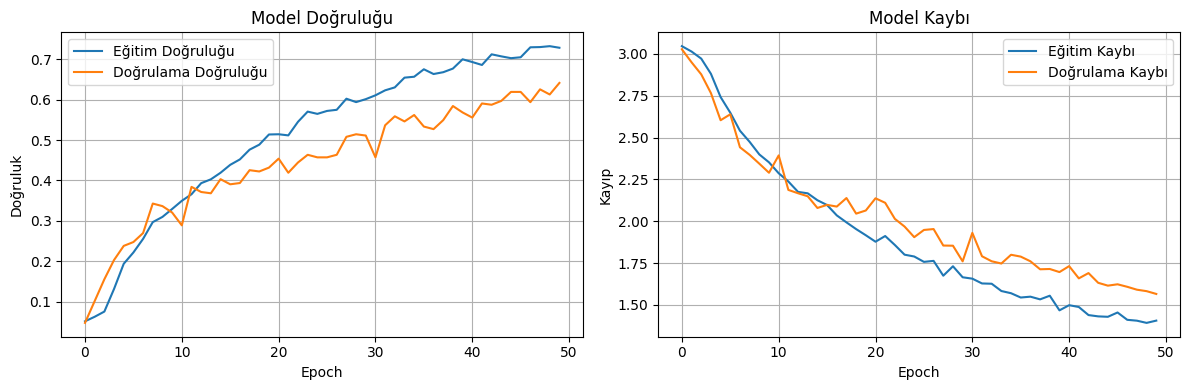

In [6]:
plot_training_history(history)

## Modeli kaydetme:
Eğitim tamamlandıktan sonra model `.keras` formatında kaydedilir. Bu sayede daha sonra test etmek veya tekrar yüklemek üzere kullanılabilir.

In [14]:
model.save("../../models/cnn/model_uc_merced.keras")